Found 1637 graphs.
Found 69 unique graphs.
{'graphs_Language_samples_undirected_G_Homer_nouns': 3.7231051293302113, 'graphs_Citation_samples_undirected_G_HepPh': 1.9175179450897009, 'graphs_Web_samples_undirected_G_Google': 2.7047500740828174, 'graphs_Web_samples_undirected_G_spam': 3.584942459168712, 'graphs_Web_samples_undirected_G_edu': 1.6298748262447813, 'graphs_Protein_samples_undirected_G_human_Figeys': 2.550329666272247, 'graphs_Transportation_samples_undirected_G_Bay': 0.6167444815007548, 'graphs_Web_samples_undirected_G_webbase': 1.60742516156458, 'graphs_Web_samples_undirected_G_EPA': 1.5128816806555065, 'graphs_Language_samples_undirected_G_Austen_nouns': 3.3846678178471667, 'graphs_Transportation_samples_undirected_G_USA': 4.776717405349235, 'graphs_Semantic_samples_undirected_G_Edinburgh': 2.292773727235892, 'graphs_Language_samples_undirected_G_Shakespeare_nouns': 4.5508287321508405, 'graphs_Language_samples_undirected_G_Whitman_nouns': 2.995424985689088, 'graphs_Transpo

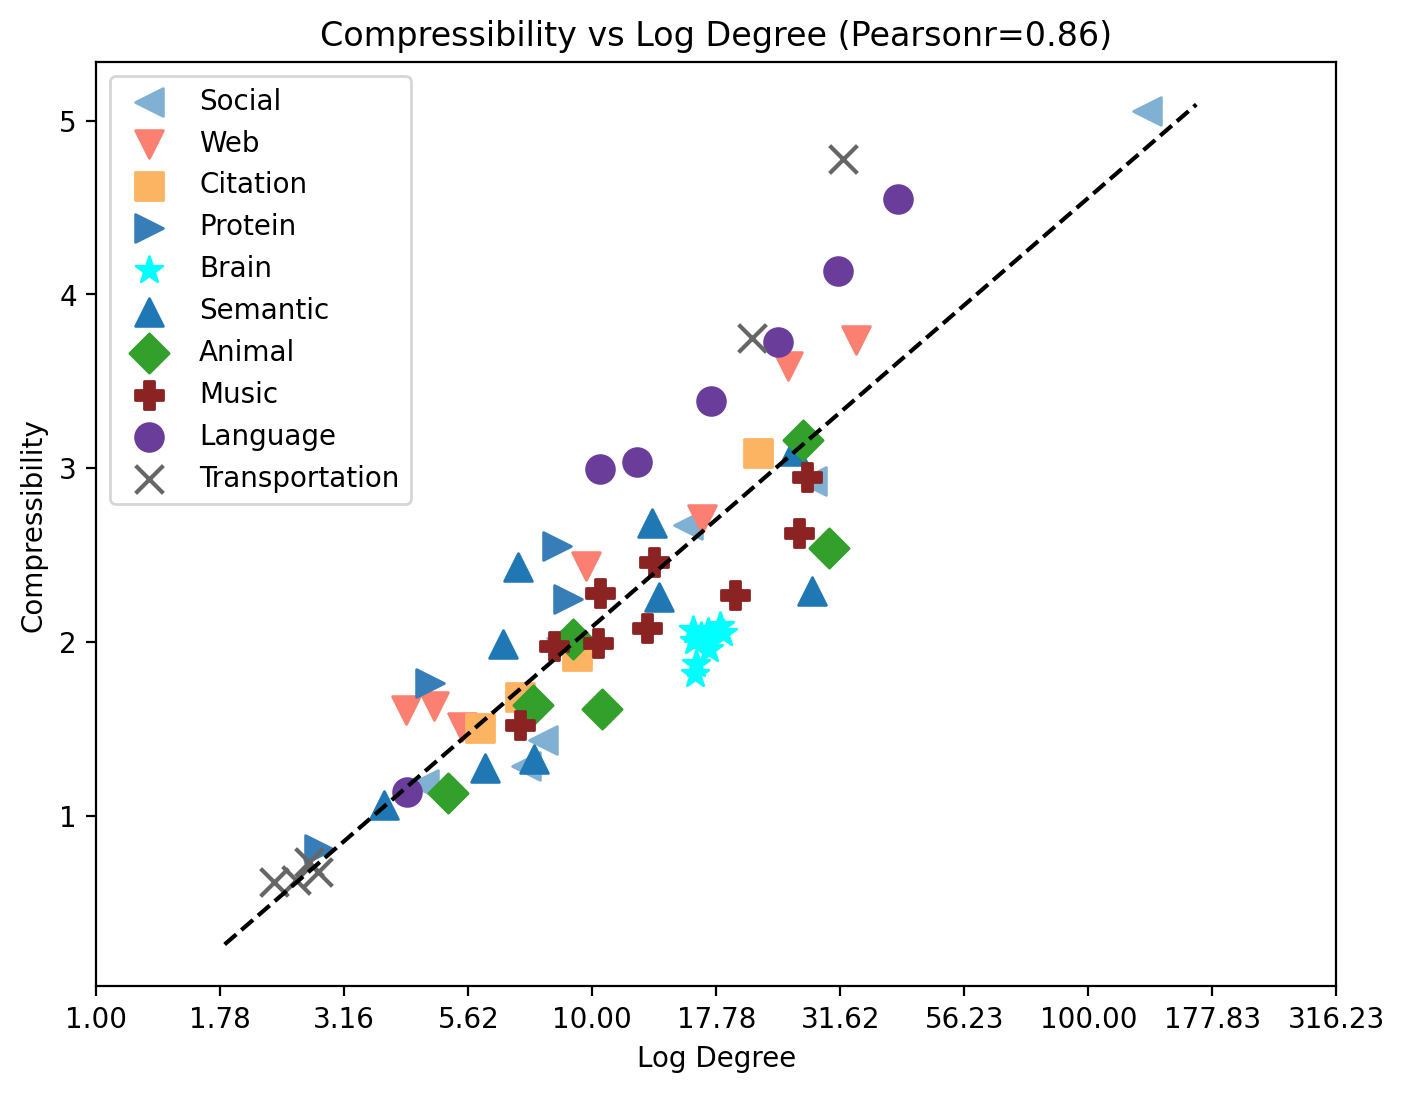

In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt

def get_compressibility(log_dir):
    rates_upper = np.load(os.path.join(log_dir, 'rates_upper.npy'))
    c = rates_upper[0] - rates_upper.mean()
    return c

graph_list = []
graph2subgraphs = {}
graph_dir = '../data/compressibility'
for root, dirs, files in os.walk(graph_dir):
    for file in files:
        if file.endswith('.npz') and 'undirected' in file:
        # if file.endswith('.npz'):
            graph_list.append(os.path.basename(file).split('.npz')[0])
print(f'Found {len(graph_list)} graphs.')
for subgraph in graph_list:
    graph = '_'.join(subgraph.split('_')[:-1])
    if graph not in graph2subgraphs:
        graph2subgraphs[graph] = []
    graph2subgraphs[graph].append(subgraph)
print(f'Found {len(graph2subgraphs)} unique graphs.')

heu5_dir = '../logs/logs_compressibility/heu_5_no_time'
heu7_dir = '../logs/logs_compressibility/heu_7_no_time'

graph2compressibility_heu5 = {}
graph2compressibility_heu7 = {}
graph2compressibility = {}
for graph in graph2subgraphs:
    subgraphs = graph2subgraphs[graph]
    compressibilities_heu5 = []
    compressibilities_heu7 = []
    compressibilities = []
    for subgraph in subgraphs:
        log_dir_heu5 = os.path.join(heu5_dir, f'rate_distortion_{subgraph}')
        log_dir_heu7 = os.path.join(heu7_dir, f'rate_distortion_{subgraph}')
        c_heu5 = get_compressibility(log_dir_heu5)
        compressibilities_heu5.append(c_heu5)
        c_heu7 = get_compressibility(log_dir_heu7)
        compressibilities_heu7.append(c_heu7)
        compressibilities.append(max(c_heu5, c_heu7))
    graph2compressibility_heu5[graph] = np.mean(compressibilities_heu5).item()
    graph2compressibility_heu7[graph] = np.mean(compressibilities_heu7).item()
    graph2compressibility[graph] = np.mean(compressibilities).item()
print(graph2compressibility)
graph2degree = {}
for graph, subgraphs in graph2subgraphs.items():
    subgraph = subgraphs[0]
    data = np.load(os.path.join(graph_dir, f'{subgraph}.npz'))
    key = data.files[0]
    adj = data[key]
    avg_degree = adj.sum(0).mean().item()
    graph2degree[graph] = avg_degree
print(graph2degree)
unique_graphs = list(graph2subgraphs.keys())
print(f'unique_graphs: {len(unique_graphs)}')
degrees = [graph2degree[g] for g in unique_graphs]
log_degrees = [np.log10(graph2degree[g]) for g in unique_graphs]
compressibilities_heu5 = [graph2compressibility_heu5[g] for g in unique_graphs]
compressibilities_heu7 = [graph2compressibility_heu7[g] for g in unique_graphs]
compressibilities = [graph2compressibility[g] for g in unique_graphs]
graph_types = [g.split('_')[1] for g in unique_graphs]
type2shape = {
    "Language": "o",       # circle
    "Music": "P",          # star
    "Web": "v",            # triangle down
    "Citation": "s",       # square
    "Animal": "D",         # diamond
    "Semantic": "^",       # triangle up
    "Brain": "*",          # star (5-point filled)
    "Social": "<",         # triangle left
    "Protein": ">",        # triangle right
    "Flight": "X",         # star (thin)
    "Transportation": "x"            # star (thicker)
}
type2color = {
    "Language": "#6A3D9A",   # 紫色
    "Music": "#8B2323",      # 棕红色
    "Web": "#FB8072",        # 浅红色
    "Citation": "#FDB462",   # 橙色
    "Animal": "#33A02C",     # 绿色
    "Semantic": "#1F78B4",   # 蓝绿色
    "Brain": "#00FFFF",      # 青色
    "Social": "#80B1D3",     # 浅蓝色
    "Protein": "#377EB8",    # 深蓝色
    "Flight": "#CCCCCC",     # 浅灰色
    "Transportation": "#666666"        # 深灰色
}
# compute the Pearson correlation coefficient between log degree and compressibility
corr_heu5 = np.corrcoef(log_degrees, compressibilities_heu5)[0, 1]
corr_heu7 = np.corrcoef(log_degrees, compressibilities_heu7)[0, 1]
corr = np.corrcoef(log_degrees, compressibilities)[0, 1]
print(f'Correlation (heu5): {corr_heu5:.4f}')
print(f'Correlation (heu7): {corr_heu7:.4f}')
print(f'Correlation (max): {corr:.4f}')
# plot compressibility vs log degree
fig, ax = plt.subplots(figsize=(8, 6), dpi=200)
for gtype in set(graph_types):
    idx = [i for i, t in enumerate(graph_types) if t == gtype]
    ax.scatter(np.array(log_degrees)[idx], np.array(compressibilities)[idx], label=gtype, color=type2color[gtype], marker=type2shape[gtype], s=100)

# add a linear fit line
m, b = np.polyfit(log_degrees, compressibilities, 1)
x = np.array([min(log_degrees) - 0.1, max(log_degrees) + 0.1])
y = m * x + b
ax.plot(x, y, color='black', linestyle='--')

ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{10**t:.2f}" for t in ticks])
ax.set_xlabel('Log Degree')
ax.set_ylabel('Compressibility')
ax.set_title(f'Compressibility vs Log Degree (Pearsonr={corr:.2f})')
ax.legend()
plt.show()